In [17]:
import numpy as np
import pandas as pd

In [55]:
best_individuals = np.load('models/best_individuals.npy')

In [19]:
import random
import yaml
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
from scoop import futures

from world import World, AgentParameters
from agent import Agent

# --- Configuration ---
CONFIG_PATH = 'configs/bosnian_war.yml'
with open(CONFIG_PATH, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

agent_ids = [a['id'] for a in config['agents']]
issue_names = [i['name'] for i in config['issues']]
battle_names = [b['name'] for b in config['battlefields']]

# Dimensions from Agent
A_ISSUE = len(Agent.ACTIONS_ISSUE)
F_ISSUE = Agent.NUM_ISSUE_FEATURES
A_BATTLE = len(Agent.ACTIONS_BATTLE)
F_BATTLE = Agent.NUM_BATTLE_FEATURES

# Hyperparameter keys and bounds
hyper_keys = [
    'initial_conflict_intensity', 'initial_negotiation_tension',
    'negotiation_tension_factor', 'initial_fatigue', 'fatigue_change_factor',
    'fatigue_factor', 'surplus_factor', 'external_pressure_factor', 'proposal_std',
    'resolved_threshold'
]
bounds = {
    'initial_conflict_intensity': (0.0, 1.0),
    'initial_negotiation_tension': (0.0, 1.0),
    'negotiation_tension_factor': (0.0, 0.5),
    'initial_fatigue': (0.0, 1.0),
    'fatigue_change_factor': (0.0, 0.5),
    'fatigue_factor': (0.0, 0.5),
    'surplus_factor': (0.0, 0.5),
    'external_pressure_factor': (0.0, 0.5),
    'proposal_std': (1.0, 20.0),
    'resolved_threshold': (0.75, 1.0)
}

# Calculate gene length
H = len(hyper_keys)
P_iw = len(agent_ids) * len(issue_names)
P_bw = len(agent_ids) * len(battle_names)
P_bl = len(agent_ids) * len(issue_names)
P_ib = len(agent_ids) * len(issue_names) * A_ISSUE * F_ISSUE
P_bb = len(agent_ids) * len(battle_names) * A_BATTLE * F_BATTLE
GENE_LENGTH = H + P_iw + P_bw + P_bl + P_ib + P_bb

def decode(individual):
    hyp = {}
    idx = 0
    # Decode hypers
    for key in hyper_keys:
        lo, hi = bounds[key]
        ind = max(0.0, min(1.0, individual[idx]))
        hyp[key] = lo + ind * (hi - lo)
        idx += 1

    # Decode agent-specific parameters
    agent_params = {}
    # Issue weights
    iw_matrix = np.array(individual[idx:idx+P_iw]).reshape(len(agent_ids), len(issue_names))
    idx += P_iw
    # Battle weights
    bw_matrix = np.array(individual[idx:idx+P_bw]).reshape(len(agent_ids), len(battle_names))
    idx += P_bw
    # Bottom-lines (0-100)
    bl_matrix = np.array(individual[idx:idx+P_bl]).reshape(len(agent_ids), len(issue_names)) * 100.0
    idx += P_bl
    # Issue betas
    ib_matrix = np.array(individual[idx:idx+P_ib]).reshape(len(agent_ids), len(issue_names), A_ISSUE, F_ISSUE)
    # scale from [0,1]
    ib_matrix = ib_matrix * 20.0 - 10.0
    idx += P_ib
    # Battle betas
    bb_matrix = np.array(individual[idx:idx+P_bb]).reshape(len(agent_ids), len(battle_names), A_BATTLE, F_BATTLE)
    bb_matrix = bb_matrix * 20.0 - 10.0
    idx += P_bb

    # Build AgentParameters for each agent
    for ai, aid in enumerate(agent_ids):
        iw = {iss: float(iw_matrix[ai, ji]) for ji, iss in enumerate(issue_names)}
        bw = {bf: float(bw_matrix[ai, jb]) for jb, bf in enumerate(battle_names)}
        bottom = {iss: float(bl_matrix[ai, ji]) for ji, iss in enumerate(issue_names)}
        issue_betas = {
            iss: ib_matrix[ai, ji] for ji, iss in enumerate(issue_names)
        }
        battle_betas = {
            bf: bb_matrix[ai, jb] for jb, bf in enumerate(battle_names)
        }
        agent_params[aid] = AgentParameters(
            issue_weights=iw,
            battle_weights=bw,
            issue_betas=issue_betas,
            battle_betas=battle_betas,
            issue_bottomlines=bottom
        )

    return hyp, agent_params

In [ ]:
hyp, agent_params = decode(best_individuals[2])

In [21]:
hyp

{'initial_conflict_intensity': np.float64(0.7052429754251015),
 'initial_negotiation_tension': 0.0,
 'negotiation_tension_factor': 0.0,
 'initial_fatigue': np.float64(0.41197895038549254),
 'fatigue_change_factor': 0.5,
 'fatigue_factor': np.float64(0.25430496521572665),
 'surplus_factor': np.float64(0.3120223689963858),
 'external_pressure_factor': np.float64(0.3070243162257224),
 'proposal_std': np.float64(1.847523867041673),
 'resolved_threshold': np.float64(0.8868539401746482)}

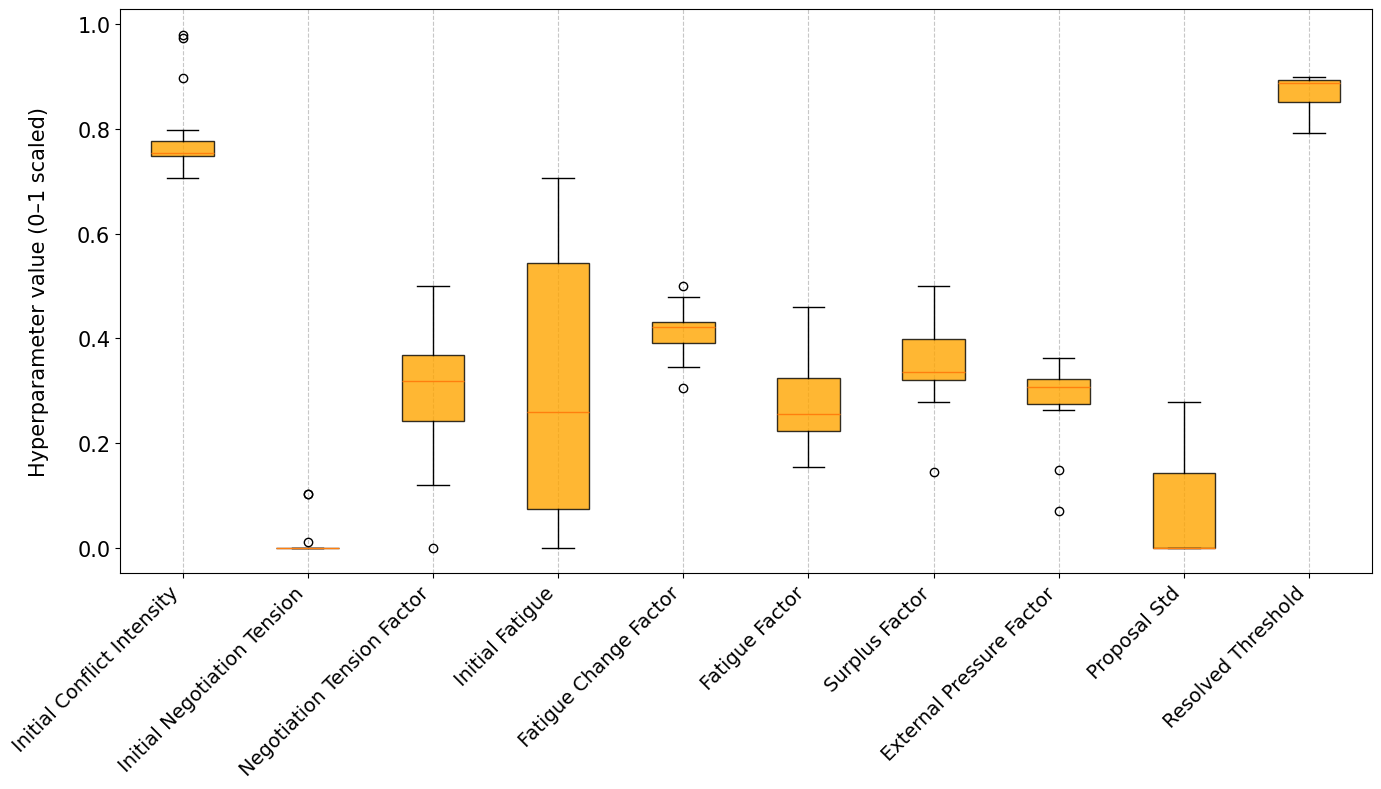

In [ ]:
import matplotlib.pyplot as plt

# Extract the hyperparameters from each of the 20 best individuals
hyps = [decode(ind)[0] for ind in best_individuals]

hyper_keys = [
    'initial_conflict_intensity', 'initial_negotiation_tension',
    'negotiation_tension_factor', 'initial_fatigue', 'fatigue_change_factor',
    'fatigue_factor', 'surplus_factor', 'external_pressure_factor',
    'proposal_std', 'resolved_threshold'
]
hyper_data = np.array([[ind[k] for k in hyper_keys] for ind in hyps])
hyper_data[:, 8] = (hyper_data[:, 8] - 1.0) / 20.0  # Scale proposal_std to [0,1]

hyper_keys_pretty = [key.replace("_", " ").title() for key in hyper_keys]

plt.figure(figsize=(14, 8))
plt.boxplot(hyper_data, patch_artist=True, boxprops=dict(facecolor='orange', alpha=0.8), tick_labels=hyper_keys_pretty)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=15)
plt.ylabel("Hyperparameter value (0–1 scaled)", fontsize=15, labelpad=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('figs/hyper.png', dpi=300)
plt.show()

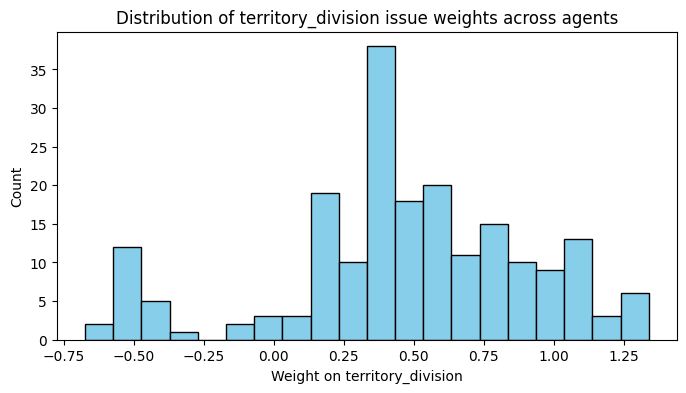

In [56]:
territory_weights = []
for ind in best_individuals:
    _, agent_params = decode(ind)
    for agent_id, params in agent_params.items():
        territory_weights.append(params.issue_weights['territory_division'])

plt.figure(figsize=(8, 4))
plt.hist(territory_weights, bins=20, color='skyblue', edgecolor='k')
plt.xlabel("Weight on territory_division")
plt.ylabel("Count")
plt.title("Distribution of territory_division issue weights across agents")
plt.show()


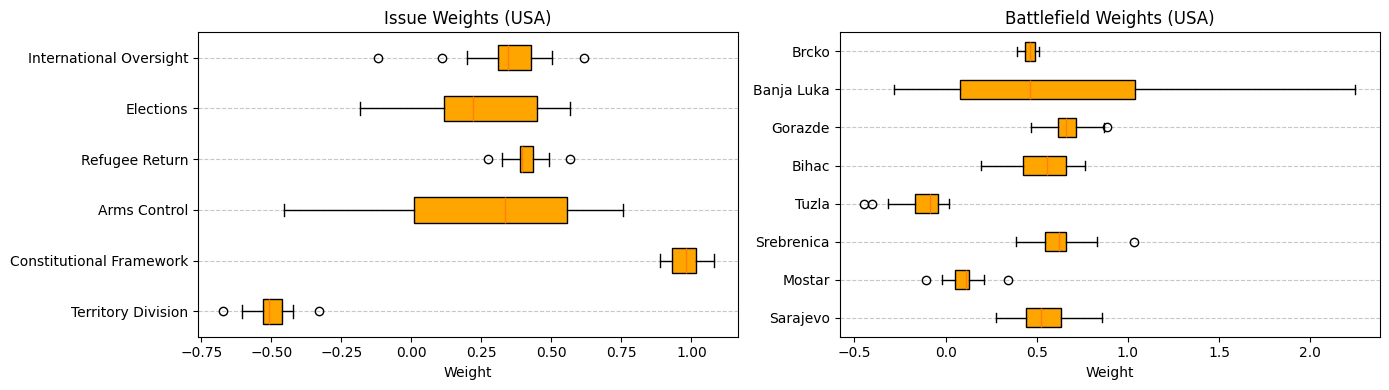

In [64]:
import numpy as np
import yaml
import matplotlib.pyplot as plt

# Paths
CONFIG_PATH = 'configs/bosnian_war.yml'
BEST_INDIVIDUALS_PATH = 'models/best_individuals.npy'  # Adjust if needed

# Load configuration
with open(CONFIG_PATH, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

agent_ids = [a['id'] for a in config['agents']]
issue_names = [i['name'] for i in config['issues']]
battle_names = [b['name'] for b in config['battlefields']]

# Load best individuals
best_individuals = np.load(BEST_INDIVIDUALS_PATH, allow_pickle=True)

# Hyperparameter keys
hyper_keys = [
    'initial_conflict_intensity', 'initial_negotiation_tension',
    'negotiation_tension_factor', 'initial_fatigue', 'fatigue_change_factor',
    'fatigue_factor', 'surplus_factor', 'external_pressure_factor', 'proposal_std',
    'resolved_threshold'
]

# Decode function
def decode_weights(individual):
    idx = len(hyper_keys)
    # Issue weights
    iw_matrix = np.array(individual[idx:idx + len(agent_ids) * len(issue_names)]).reshape(len(agent_ids), len(issue_names))
    idx += len(agent_ids) * len(issue_names)
    # Battle weights
    bw_matrix = np.array(individual[idx:idx + len(agent_ids) * len(battle_names)]).reshape(len(agent_ids), len(battle_names))
    return iw_matrix, bw_matrix

# Index for USA
usa_index = agent_ids.index("USA")

# Collect weights across top 20 individuals
usa_iw_all = []
usa_bw_all = []
for ind in best_individuals:
    iw_matrix, bw_matrix = decode_weights(ind)
    usa_iw_all.append(iw_matrix[usa_index, :])
    usa_bw_all.append(bw_matrix[usa_index, :])

# Convert to numpy arrays
usa_iw_all = np.array(usa_iw_all)
usa_bw_all = np.array(usa_bw_all)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Issue Weights Boxplot
axes[0].boxplot(usa_iw_all, vert=False, patch_artist=True, boxprops=dict(facecolor='orange'))
axes[0].set_title('Issue Weights (USA)')
axes[0].set_xlabel('Weight')
axes[0].set_yticks(range(1, len(issue_names)+1))
axes[0].set_yticklabels([name.replace('_', ' ').title() for name in issue_names])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Battlefield Weights Boxplot
axes[1].boxplot(usa_bw_all, vert=False, patch_artist=True, boxprops=dict(facecolor='orange'))
axes[1].set_title('Battlefield Weights (USA)')
axes[1].set_xlabel('Weight')
axes[1].set_yticks(range(1, len(battle_names)+1))
axes[1].set_yticklabels([name.replace('_', ' ').title() for name in battle_names])
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('figs/usa_weights.png', dpi=300)
plt.show()


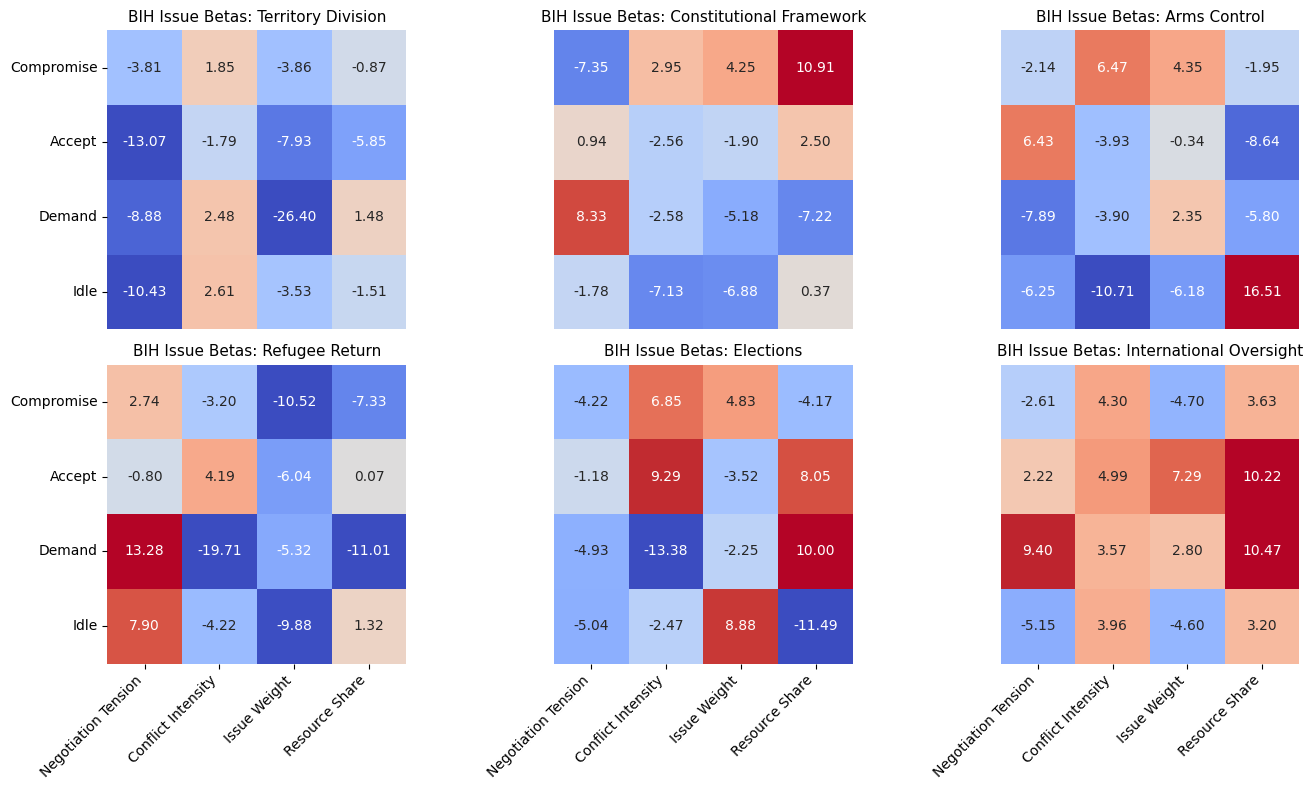

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Labels
actions = ['Compromise', 'Accept', 'Demand', 'Idle']
features = [
    'Negotiation Tension',
    'Conflict Intensity',
    'Issue Weight',
    'Resource Share'
]

# Compute the average beta matrices across best individuals for BIH
sample_agent_id = 'BIH'
issue_beta_averages = {}
for issue in issue_names:
    avg_matrix = np.zeros((4, 4))
    for ind in best_individuals:
        _, agent_params = decode(ind)
        beta_matrix = agent_params[sample_agent_id].issue_betas[issue]
        avg_matrix += beta_matrix
    avg_matrix /= len(best_individuals)
    issue_beta_averages[issue] = avg_matrix

# Plotting in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, issue in enumerate(issue_names):
    ax = axes[idx]
    sns.heatmap(
        issue_beta_averages[issue],
        annot=True, fmt=".2f",
        cmap='coolwarm', ax=ax,
        cbar=False,
        square=True,
        vmin=-10, vmax=10,
        xticklabels=features if idx >= 3 else [],
        yticklabels=actions if idx % 3 == 0 else []
    )
    ax.set_title(f"BIH Issue Betas: {issue.replace('_', ' ').title()}", fontsize=11)
    
    # Rotate x-axis labels only for bottom plots
    if idx >= 3:
        ax.set_xticklabels(features, rotation=45, ha='right')
    # Y-axis labels remain upright
    if idx % 3 == 0:
        ax.set_yticklabels(actions, rotation=0)

plt.tight_layout()
plt.savefig('figs/bih_issue_betas.png', dpi=300)
plt.show()